In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from rikabplotlib.plot_utils import newplot

import torch
import zuko

In [ ]:
# Physics Parameters
E0 = 500
R = 0.4
N = 1


# Training Params
MODE = "UNIFORM_SAMPLES" #"UNIFORM_SAMPLES"

# LOSS = "FORWARD"
# LOSS = "REVERSE"
LOSS = "residual"
# LOSS = "ratioMSE"

DEBUG = True

epochs = 1250*2
batch_size = 32
batch_conditional = 64
lr = 1e-3
auxiliary_params = 0 # Number of auxiliary parameters to use in the model, 0 has different behavior!
num_transforms = 3 # I think this is the number of layers?
hidden_features=(8, 8)
x_range = (0, 1) # Range of x values to train on, should be at least as large as the support of the data


In [3]:
# Distribution Choices:

def Gaussian(x):

    mean = 0
    std = 1

    # Gaussian 
    p = 1/np.sqrt(2 * np.pi  * std**2) * np.exp(- (x - mean)**2 / 2 / std**2)
    return p

def Uniform(x): 

    return Theta(x) * Theta(1 - x)


def Theta(x):
    return torch.where(x > 0, torch.ones_like(x), torch.zeros_like(x))

def alpha_s(scale, lambda_qcd = 0.2):
    beta_0 = 11 - 2/3 * 3
    return 4 * np.pi / (beta_0 * torch.log(scale**2 / lambda_qcd**2))

def dalpha_dscale(scale):
    lambda_qcd = 0.2
    beta_0 = 11 - 2/3 * 3
    return -4 * np.pi / beta_0  / (torch.log(scale**2 / lambda_qcd**2) ** 2) * 2 / scale


def alpha_s(scale, lambda_qcd = 0.2):
    beta_0 = 11 - 2/3 * 3
    return 4 * np.pi / (beta_0 * torch.log(scale**2 / lambda_qcd**2))

def lambda_qcd(alpha0, scale0):

    beta_0 = 11 - 2/3 * 3
    
    return scale0 * torch.exp(-1 * (2 * np.pi) / (  beta_0 * alpha0))

def run_alpha(alpha0, scale0, scale1):

    beta_0 = 11 - 2/3 * 3
    alpha = alpha0 / (1 + alpha0*beta_0 / (4 * np.pi) * torch.log(scale1**2 / scale0**2))

    # # if alpha is above 1 or below 0, set it to 1
    # alpha = torch.where(alpha > 1, torch.ones_like(alpha), alpha)
    # alpha = torch.where(alpha < 0, torch.ones_like(alpha), alpha)
    

    return alpha


def LO_angularity(lambda_, alpha, beta = 1):

    # If lambda and alpha are tensors, set lambda = [:, None] and alpha = [None, :]
    if alpha.dim() == 1:
        lambda_ = lambda_[:, None]
        alpha = alpha[None, :]
    



    scale = E0 * torch.pow(lambda_, 1 / (beta))
    # alpha_s_scale = run_alpha(alpha, 91, scale)
    alpha_s_scale = alpha 
    C_F = 4/3
    C_A = 3



    return -torch.nan_to_num(((2 * alpha_s_scale * C_F / (1 * np.pi * beta * R)) * torch.log(lambda_ ) / lambda_ * Theta(1 - lambda_)) )* Theta(lambda_)* Theta(1-lambda_)



def df_dx(lambda_, beta = 1):

    lcqd = lambda_qcd(0.118, 91)
    beta_0 = 11 - 2/3 * 3

    scale = E0 * torch.pow(lambda_, 1 / (beta))
    alpha_s_scale = alpha_s(scale)

    C_F = 4/3


    dLO_dalpha =  -C_F / (beta * R *  np.pi) * torch.pow(torch.log(lambda_), 2)
    dalpha_dscale = -4 * np.pi / beta_0  / (torch.log(scale**2 / lambda_qcd**2) ** 2) * 2 / scale
    dscale_dlambda = E0

    return dLO_dalpha * dalpha_dscale * dscale_dlambda

   

def LL_angularity(lambda_, alpha, beta = 1):

    scale = E0 * torch.pow(lambda_, 1 / (beta))
    alpha_s_scale = run_alpha(alpha, 91, scale)
    alpha_s_scale = alpha
    C_F = 4/3
    C_A = 3

    p = torch.nan_to_num(LO_angularity(lambda_, alpha_s_scale, beta) * torch.exp(-1 * alpha_s_scale * C_F / (beta * R *  np.pi) * torch.pow(torch.log(lambda_), 2)) )

    return (p * Theta(lambda_) * Theta(1 - lambda_))



def LL_exact_angularity(lambda_, alpha,  beta = 1):

    scale = E0 * torch.pow(lambda_, 1 / (beta))
    alpha_s_scale = run_alpha(alpha, 91, scale)
    C_F = 4/3
    C_A = 3

    p = torch.nan_to_num((LO_angularity(lambda_, alpha_s_scale, beta) + df_dx(lambda_, beta)) * torch.exp(-1 * alpha_s_scale * C_F / (beta * R *  np.pi) * torch.pow(torch.log(lambda_), 2)) )

    return  (p * Theta(lambda_) * Theta(1 - lambda_)) * 1


# Choice of target
target_p = LO_angularity

torch.Size([7, 5])


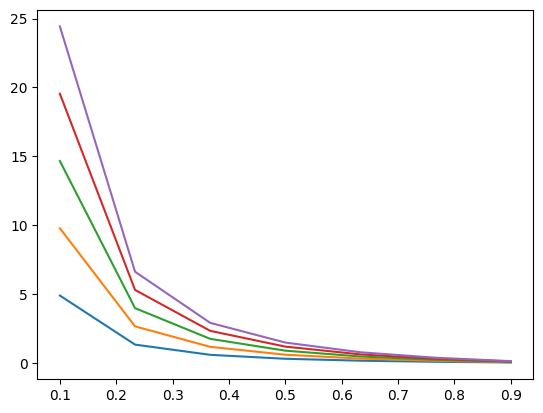

In [4]:
alphas = torch.linspace(0.1, 0.5, 5)
lambdas = torch.linspace(0.1, 0.9, 7)

p = LO_angularity(lambdas, alphas)
print(p.shape)

# plot the target distribution
for i, alpha in enumerate(alphas):
    plt.plot(lambdas, p[:,i], label = f"alpha = {alpha}", c = plt.cm.tab10(i))

/tmp/ipykernel_4256/2700199471.py:23: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label = r"$\alpha_s$")


(-1.5, 1.5)

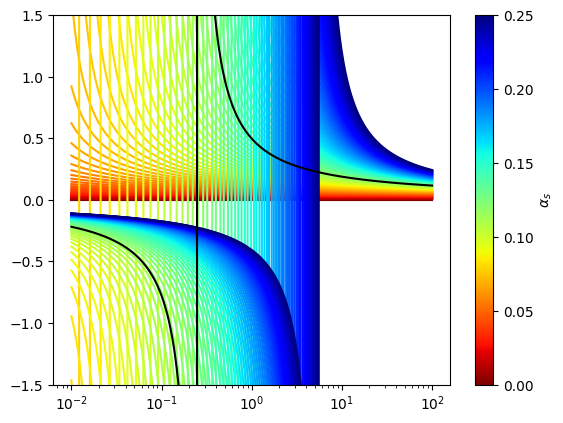

In [5]:
# running of alpha

Q = np.logspace(-2, 2, 1000)

alpha_choices = np.linspace(0, 0.25, 100)
# jet color scheme
cmap = plt.get_cmap("jet_r")
colors = cmap(np.linspace(0, 1, len(alpha_choices)))

for (i, alpha) in enumerate(alpha_choices):



    alphas = run_alpha(alpha, 91, torch.tensor(Q)).detach().numpy()
    plt.plot(Q, alphas, label = f"alpha = {alpha}", color = colors[i])

alphas = run_alpha(0.118, 91, torch.tensor(Q)).detach().numpy()


# colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=0.25))
sm.set_array([])
plt.colorbar(sm, label = r"$\alpha_s$")

plt.plot(Q, alphas, label = f"alpha = 0.118", color = "black")
plt.xscale("log")

plt.ylim(-1.5, 1.5)
# plt.legend()

0.9919563953682835
0.9919563953682835
0.9919563953682835
0.9919563953682835


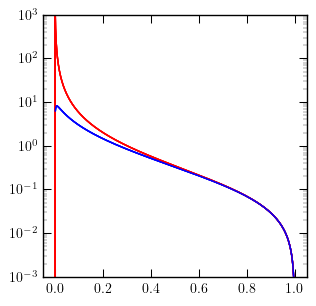

In [6]:
# Plot the target distribution

fig, ax = newplot("column")

for alpha in np.logspace(-3, 0, 4):

    alpha = torch.tensor(0.118)

    xs = np.linspace(0, 1, 1000)
    ys = target_p(torch.tensor(xs), alpha).detach().numpy()
    ax.plot(xs, ys, label="LL Angularity", color = "red")

    plt.yscale("log")

    # Plot the LL and LL_exact distributions
    xs = np.linspace(0.002, 0.999, 1000)
    ys = LL_angularity(torch.tensor(xs), alpha).detach().numpy()
    print(np.trapz(ys, xs))
    ax.plot(xs, ys, label="LL Angularity", color = "blue")

    # ys = LL_exact_angularity(torch.tensor(xs), alpha).detach().numpy()
    # print(np.trapz(ys, xs))
    # ax.plot(xs, ys, label="LL Exact Angularity", color = "green")

    plt.ylim(1e-3, 1e3)



In [7]:
from zuko.distributions import DiagNormal
from zuko.flows import UnconditionalDistribution

# Initialize the flow

# Can choose: NSF, MAF, NICE
flow = zuko.flows.BPF(features = auxiliary_params + 1, context=1, transforms= num_transforms, hidden_features=hidden_features)

# # Hack to make the flow bounded between 0 and 1
# flow = zuko.flows.Flow(transform = [flow, AffineSigmoid(0,1)], base =UnconditionalDistribution(
#         DiagNormal,
#         torch.zeros(3),
#         torch.ones(3),
#         buffer=True,
#     ),)

def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

def inverse_sigmoid(x):
    return torch.log(x / (1 - x))

def log_abs_det_jacobian_sigmoid(x,):
    sigma = sigmoid(x)
    return torch.abs(torch.log(sigma) + torch.log(1 - sigma))

def counting_parameter(x, C = 1):
    return C * alpha_s(E0 * x) * torch.log(1/x) / x 


print(flow)

# print list of all attributes of the flow
print(flow.__dict__.keys())



pytorch_total_params = sum(p.numel() for p in flow.parameters() if p.requires_grad)
print(f"Numb. trainable params: {pytorch_total_params}")


BPF(
  (transform): LazyComposedTransform(
    (0-2): 3 x ElementWiseTransform(
      (base): BoundedBernsteinTransform()
      (hyper): MLP(
        (0): Linear(in_features=1, out_features=8, bias=True)
        (1): ReLU()
        (2): Linear(in_features=8, out_features=8, bias=True)
        (3): ReLU()
        (4): Linear(in_features=8, out_features=17, bias=True)
      )
    )
  )
  (base): UnconditionalDistribution(DiagNormal(loc: tensor([0.]), scale: tensor([1.])))
)
dict_keys(['training', '_parameters', '_buffers', '_non_persistent_buffers_set', '_backward_pre_hooks', '_backward_hooks', '_is_full_backward_hook', '_forward_hooks', '_forward_hooks_with_kwargs', '_forward_hooks_always_called', '_forward_pre_hooks', '_forward_pre_hooks_with_kwargs', '_state_dict_hooks', '_state_dict_pre_hooks', '_load_state_dict_pre_hooks', '_load_state_dict_post_hooks', '_modules'])
Numb. trainable params: 723


In [8]:
from torch.autograd.functional import jacobian


# Training Loop

PLOT_EACH_EPOCH = False


def q_given_c(c):
    return flow(c).sample((batch_size,))

def train(epochs, batch_size, pre_train = False, lr = 1e-3):

    optimizer = torch.optim.AdamW(flow.parameters(), lr=lr)


    losses = []
    training_cs = []
    logps = []
    logqs = []
    logJs = []
    xss = []


    t = tqdm(range(epochs))

        # Sample a bunch of alphas from an exponential distribution
    alpha_batch = torch.distributions.Exponential(1 / 0.118).sample((batch_size,))



    for epoch in t:

        # Generate a random cutoff alpha, exponentially distributed
        
        reroll = True
        while reroll:
            # alpha = torch.distributions.Exponential(1 / 0.118).sample()

            alpha = torch.distributions.Exponential(1 / 0.118).sample((batch_conditional,))
            # alpha = torch.rand(batch_conditional)
            if torch.all(alpha) > 0.001:
                reroll = False
                

        # x_range = (0.5, 0.99)
        c = torch.rand(1) * (x_range[1] - x_range[0]) + x_range[0]
        
        

        # Used to be called "REVERSE" / "No samples"
        if MODE == "UNIFORM_SAMPLES":

            reroll = True

            while reroll:
                xs = torch.rand(batch_size, auxiliary_params + 1)  * (x_range[1] - x_range[0]) + x_range[0] 
                # xs[:,0] = xs[:,0] * (1 - c) + c
                # xs = torch.zeros(batch_size, auxiliary_params + 1) 
                # xs[:,0] = torch.linspace(0.001, 0.999, batch_size)

                # Auxillary variable -- uniform. alternatively set to const
                if auxiliary_params > 0:
                    xs[:,1:] = torch.rand(batch_size, auxiliary_params)
                    # xs[:,1] = torch.linspace(0.001, 0.999, batch_size)

                # Check if any x are 0 or 1 to float point error, reroll if so
                epsilon = 1e-6
                if torch.any(xs <= epsilon) or torch.any(xs >= 1 - epsilon):
                    reroll = True
                else:
                    reroll = False

            # Note for log_prob to work, we need to pass a tensor of shape (batch_size, >=1)
            
            def q_given_alpha(xs, alpha):
                # return LL_angularity(xs[:,0], alpha)

                logJ = torch.nansum(log_abs_det_jacobian_sigmoid(inverse_sigmoid(xs)), axis = 1)

                qs = torch.zeros((batch_size, alpha.shape[0]))
                for i in range(alpha.shape[0]):
                    qs[:,i] = (flow(alpha[i].reshape(1,1)).log_prob(inverse_sigmoid(xs)) + logJ).exp()
                return qs
            
            def p_given_alpha(xs, alpha):
                return (target_p(xs[:,0], alpha)) # * target_p(xs[:,1], alpha))


            epsilon = 1e-6
            def residual(xs, alpha):           
                p = p_given_alpha(xs, alpha) 
                q = q_given_alpha(xs, alpha)

                # return (p + epsilon) / (q + epsilon) # * LL_angularity(xs[:,0], alpha)
                # return  p_given_alpha(xs, alpha) - q_given_alpha(xs, alpha) # * LL_angularity(xs[:,0], alpha)
                return  1 * (torch.log((p + epsilon) / (q + epsilon))) #* (p + epsilon) / (q + epsilon) # * LL_angularity(xs[:,0], alpha)
            




            def helper_q(alpha):
                return q_given_alpha(xs, alpha)
            
            def helper_p(alpha):
                return p_given_alpha(xs, alpha)
            
            def q_derivative(alpha):

                # print(alpha.shape)
                q1 = torch.zeros((batch_size, batch_conditional))
                for (i, a) in enumerate(alpha):

                    a = torch.tensor([a.item(),])
                    q1[:,i] = jacobian(helper_q, a, create_graph=True, vectorize=False).diagonal(dim1=1, dim2=2)[:,0]

                return q1
            
            def p_derivative(alpha):
                    
                # print(alpha.shape)
                p1 = torch.zeros((batch_size, batch_conditional))
                for (i, a) in enumerate(alpha):
                    a = torch.tensor([a.item(),])
                    p1[:,i] = jacobian(helper_p, a, create_graph=True, vectorize=False).diagonal(dim1=1, dim2=2)[:,0]

                return p1
        


            if pre_train:
                
                loss = 0

                p = p_given_alpha(xs, alpha) 
                q = q_given_alpha(xs, alpha)

                logp = torch.log(torch.abs(p))
                argp = torch.where(p < 0, np.pi, 0)
                logq = torch.log(torch.abs(q))

                term1 = torch.square(logp - logq)
                term2 = torch.square(argp)


                # residual_0 = residual(xs, torch.tensor([alpha.item()]))
                # with torch.no_grad():
                #     if epoch == 0:
                #         residual_0_norm = 1 + 0 * torch.mean(residual_0 + epsilon) * 10
                # residual_0 = residual_0 / residual_0_norm

                weight = xs[:,0] / torch.log(1/xs[:,0])*0 + 1

                # print(weight.shape, term1.shape, term2.shape)
                loss = torch.nanmean(weight[:,None] * (term1 + term2))

                if epoch == 0:
                    loss_norm = loss.item()
                
                loss = loss / loss_norm 


            else:

                # p = torch.abs(p_given_alpha(xs, alpha))
                # q = q_given_alpha(xs, torch.tensor([alpha.item(),]))
            
                alpha_0 = torch.zeros_like(alpha)
                loss = 0
                residual_0 = q_given_alpha(xs, alpha_0)
                residual_1 = q_derivative(alpha_0)

                p_0 = p_given_alpha(xs, alpha_0)
                p_1 = p_derivative(alpha_0)

                # without gradients, divide by the mean of the residuals
                with torch.no_grad():

                    if epoch == 0:
                        residual_0_norm = 1 + 0*(torch.mean(residual_0 + epsilon) * 10)
                        residual_1_norm =  1 + 0*(torch.mean(residual_1 + epsilon) * 10)
                
                # residual_0 = residual_0 / residual_0_norm
                # residual_1 = residual_1 / residual_1_norm

                q_derivatives = [residual_0, residual_1]
                p_derivatives = [p_0, p_1]
                # print(residual_0, residual_1)

                N = 1

                def taylor_q_given_alpha(xs, alpha):
                    temp = 0
                    for n in range(N + 1):
                        temp += torch.pow(alpha, n) * q_derivatives[n] / torch.math.factorial(n)
                    return temp

                def taylor_p_given_alpha(xs, alpha):
                    temp = 0
                    for n in range(N + 1):
                        temp += torch.pow(alpha, n) * p_derivatives[n] / torch.math.factorial(n)
                    return temp

                # def taylor_p_given_alpha(xs, alpha):
                #     return target_p(xs[:,0], alpha)
                
                def taylor_residual(xs, alpha):
                    return torch.nan_to_num((torch.log(taylor_p_given_alpha(xs, alpha) + epsilon) - torch.log(taylor_q_given_alpha(xs, alpha) + epsilon ) ))
                
                # alpha_tensor = torch.tensor([alpha.item(),])
                weight = Theta(xs - 0.1)[:,0]
                total_loss = weight[:,None] * taylor_residual(xs, alpha)  * taylor_residual(xs, alpha) #  (torch.log(q + epsilon) - torch.log(p + epsilon)) 
                loss = total_loss.mean()

                if epoch == 0:
                    loss_norm = loss.item()

                
                # loss = loss / loss_norm 


              
                d_losses = []


                for n in range(N + 1):
                    # sum_derivatives += torch.pow(alpha_batch[None, :], n) *  derivatives[n][:,None] / torch.math.factorial(n)
                    d_losses.append(torch.nanmean(weight[:,None] * ((q_derivatives[n] + epsilon) - (p_derivatives[n] + epsilon))**2))

    
            


        loss.backward()


        # Gradient Descent
        optimizer.step()
        optimizer.zero_grad()


        training_cs.append(alpha.mean())
        losses.append(loss.item())
        # t.set_description(f"Loss: {loss.item()  }, Aux Loss: {loss_aux.item() } (Fraction: {loss_aux.item() / loss.item() })")
        
        if pre_train:
            t.set_description(f"Loss: {loss.item()  }")
        else:

            t.set_description(f"Loss: {loss.item()}, d_Losses: {d_losses}")

    return losses, training_cs, 


def logq_given_alpha(xs, alpha):
    logJ = torch.sum(log_abs_det_jacobian_sigmoid(inverse_sigmoid(xs)), axis = 1)
    ys = (flow(alpha).log_prob(inverse_sigmoid(xs)) + logJ) #* LL_angularity(xs[:,0], c)
    return ys


In [ ]:

# fig, ax = newplot("column")
# xs = 0.5 * torch.rand((1000, auxiliary_params + 1))
# xs[:,0] = torch.linspace(0.001, 0.999, 1000)
# ys = logq_given_alpha(xs, torch.tensor([0.118])).exp().detach().numpy()
# ax.plot(xs[:,0], ys, label="test", color = "red")
# ys = target_p(xs[:,0], torch.tensor([0.118])).detach().numpy()
# ax.plot(xs[:,0], ys, label="test", color = "black")
# plt.ylim(1e-3, 1e3)
# plt.yscale("log")

# losses, training_cs =  train(epochs = 1000, batch_size=512, pre_train = True, lr = 1e-2)
# torch.save(flow.state_dict(), f"rikab_model")

# fig, ax = newplot("column")

# cmap = plt.get_cmap("jet")

# losses = np.array(losses)
# training_cs = np.array(training_cs)

# ax.scatter(np.arange(len(losses)), losses, c = 1-training_cs[:len(training_cs)], cmap = cmap)
# plt.yscale("log")

# fig, ax = newplot("column")
# xs = 0.5 * torch.rand((1000, auxiliary_params + 1))
# xs[:,0] = torch.linspace(0.001, 0.999, 1000)
# ys = logq_given_alpha(xs, torch.tensor([0.118])).exp().detach().numpy()
# ax.plot(xs[:,0], ys, label="test", color = "red")
# ys = target_p(xs[:,0], torch.tensor([0.118])).detach().numpy()
# ax.plot(xs[:,0], ys, label="test", color = "black")
# plt.ylim(1e-3, 1e3)
# plt.yscale("log")




flow.load_state_dict(torch.load("rikab_model"))
flow.eval()
losses, training_cs =  train(epochs = 250, batch_size=128 , pre_train = False, lr = 1e-2)
fig, ax = newplot("column")

cmap = plt.get_cmap("jet")

losses = np.array(losses)
training_cs = np.array(training_cs)

ax.scatter(np.arange(len(losses)), losses, c = 1-training_cs[:len(training_cs)], cmap = cmap)
plt.yscale("log")


/tmp/ipykernel_4256/3090413229.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  flow.load_state_dict(torch.load("rikab_model"))
Loss: 0.4817909002304077, d_Losses: [tens

tensor([0.2500, 0.2222, 0.1944, 0.1667, 0.1389, 0.1111, 0.0833, 0.0556, 0.0278,
        0.0000])


/tmp/ipykernel_73033/287833743.py:91: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label=r"$\alpha_s(m_Z)$")


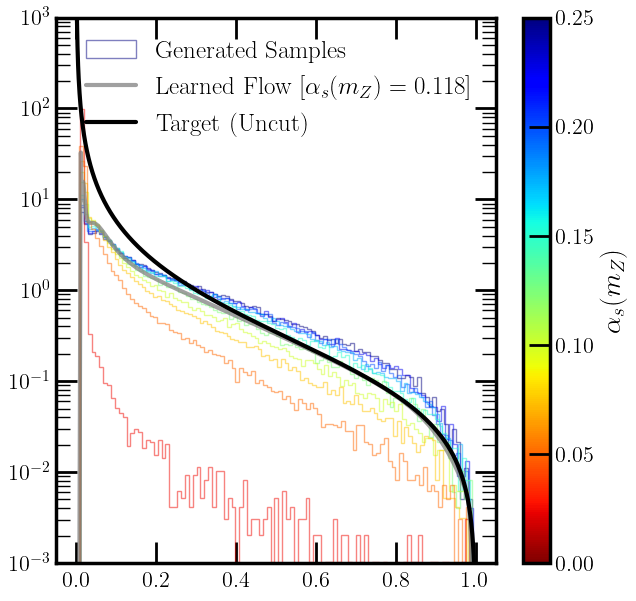

In [ ]:
# Plot distribution of xs

fig, ax = newplot("full")
cs = torch.linspace(0, 0.25, 10).flip(0)
print(cs)

# cs = [0.5]

DRAW_NF_HIST = True
DRAW_NF_LINES = False
aux_draws = 5


for i in range(len(cs)):


    # Draw hist
    c = torch.tensor([cs[i],])

    if DRAW_NF_HIST:
        samples = sigmoid(flow(c).sample((100000,)))
        x_samples = samples[:,0].detach().numpy()
        aux_samples = samples[:,1:].detach().numpy()

        jet_color = plt.get_cmap("jet")(  i / 10)
        if i == 0:
            label = "Generated Samples"
        else:
            label = None
        ax.hist(x_samples, bins=100, density=True, color = jet_color, alpha = 0.5, label = label, histtype="step")

    if DRAW_NF_LINES:

        for aux_draw in range(1):
            xs = torch.rand(10000, auxiliary_params + 1) * (x_range[1] - x_range[0]) + x_range[0]
            
            # Sort the first column
            xs = xs[torch.argsort(xs[:,0])]
            xs[:,1:] = torch.rand(1) * torch.rand((10000, auxiliary_params))
            

            # logJ = torch.sum(log_abs_det_jacobian_sigmoid(inverse_sigmoid(xs)), axis = 1)
            ys = logq_given_alpha(xs, c).exp() #* LL_angularity(xs[:,0], c)

            xs = xs[:,0].detach().numpy().flatten()
            ys = np.nan_to_num(ys.detach().numpy().flatten())

            print (c, np.trapz(ys, xs))

            np.save(f"plotfiles/theta_ys_{cs[i]}.npy", np.array([xs, ys]))


            jet_color = plt.get_cmap("jet")( i / 10)
            if i == 0 and aux_draw == 0:
                label = "Learned Flow"
            else:
                label = None

            ax.plot(xs, ys, color = jet_color, lw = 1, alpha = 0.5, label = label)

            # ax.vlines(cs[i], 0, target_p(c), color = jet_color, linestyle = "--", alpha = 0.25, lw = 0.5)



alpha0 = torch.tensor([0.118 / 1,])
xs = torch.rand(10000, auxiliary_params + 1) * (x_range[1] - x_range[0]) + x_range[0]
            
# Sort the first column
xs = xs[torch.argsort(xs[:,0])]
xs[:,1:] = torch.rand(1) * torch.rand((10000, auxiliary_params))


logJ = torch.sum(log_abs_det_jacobian_sigmoid(inverse_sigmoid(xs)), axis = 1)
ys = (flow(alpha0).log_prob(inverse_sigmoid(xs)) + logJ).exp() #* LL_angularity(xs[:,0], c)

xs = xs[:,0].detach().numpy().flatten()
ys = np.nan_to_num(ys.detach().numpy().flatten())
ax.plot(xs, ys, color = "grey", lw = 3, alpha = 0.75, label = r"Learned Flow [$\alpha_s(m_Z) = 0.118$]" )



plt.plot(xs, target_p(torch.tensor(xs), alpha0)[:,0], color = "Black", label = "Target (Uncut)")
# plt.plot(xs, LL_angularity(torch.tensor(xs), alpha0)[:,0], color = "black", linestyle = "--", label = "LL Angularity", alpha = 1)
# plt.plot(xs, LL_angularity(torch.tensor(xs), alpha0), color = "black", linestyle = "--", label = "LL-exact Angularity")



# Add a colorbar
sm = plt.cm.ScalarMappable(cmap=plt.get_cmap("jet_r"), norm=plt.Normalize(vmin=0, vmax=cs[0]))
sm.set_array([])
plt.colorbar(sm, label=r"$\alpha_s(m_Z)$")




# c = torch.tensor((0.5,))
# xs = torch.zeros((10000, auxiliary_params + 1)) + 0.5
# xs[:,0] = torch.linspace(0.001, 0.999, 10000)
# logJ = torch.sum(log_abs_det_jacobian_sigmoid(inverse_sigmoid(xs)), axis = 1)
# ys = (flow(c).log_prob(inverse_sigmoid(xs)) + logJ).exp()

# print(flow(c).log_prob(inverse_sigmoid(xs)))
# print(ys)

# xs = xs[:,0].detach().numpy().flatten()
# ys = np.nan_to_num(ys.detach().numpy().flatten())
# ps = target_p(torch.tensor(xs)).detach().numpy().flatten()
# plt.plot(xs, ys, color = "red", label = "Learned Flow")
# print(ys.mean())

# c = c.detach().numpy()

cutoff = xs > 0.5


# cutoff_norm = np.trapz(ps * cutoff, xs)
# plt.plot(xs, cutoff * ps , color = "grey", label = rf"Target (Cut at $c$ = {cs[0]})")

plt.legend()

plt.yscale("log")

plt.ylim(1e-3, 1e3)

c = torch.tensor((0.5,))
samples = sigmoid(flow(c).sample((100000,)))
x_samples = samples[:,0].detach().numpy()
aux_samples = samples[:,1:].detach().numpy()


# plot the auxiliary variables
if auxiliary_params > 0:
    fig, ax = newplot("column")
    for i in range(auxiliary_params):
        plt.hist(aux_samples[:,i], bins=100, density=True, alpha = 0.5, label=f"Aux {i}")
        prob = flow(c).log_prob(samples).exp()
        # plt.scatter(aux_samples[:,i], prob.detach().numpy(), color = "red")

    plt.yscale("log")   
    plt.ylim(1e-3, 1e3)
    plt.legend()

    # correlation between auxiliary variable 1 and x
    import matplotlib as mpl
    fig, ax = newplot("column")
    bar = ax.hist2d(x_samples, aux_samples[:,0], bins=100, density=True, norm=mpl.colors.LogNorm(), cmap="Reds")
    plt.colorbar(bar[3])
    plt.xlabel("x")
    plt.ylabel("Aux 0")
#im not sure that f(x) itself is ~ p(x)



/tmp/ipykernel_73033/3282397249.py:36: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(2, 1, 1)


torch.Size([100, 1]) torch.Size([100, 1]) torch.Size([1]) torch.Size([1])
(100, 1)
(100,)
torch.Size([100, 1]) torch.Size([100, 1]) torch.Size([1]) torch.Size([1])
torch.Size([100, 1]) torch.Size([100, 1]) torch.Size([1]) torch.Size([1])
(100, 1)
(100,)
torch.Size([100, 1]) torch.Size([100, 1]) torch.Size([1]) torch.Size([1])
torch.Size([100, 1]) torch.Size([100, 1]) torch.Size([1]) torch.Size([1])
(100, 1)
(100,)
torch.Size([100, 1]) torch.Size([100, 1]) torch.Size([1]) torch.Size([1])


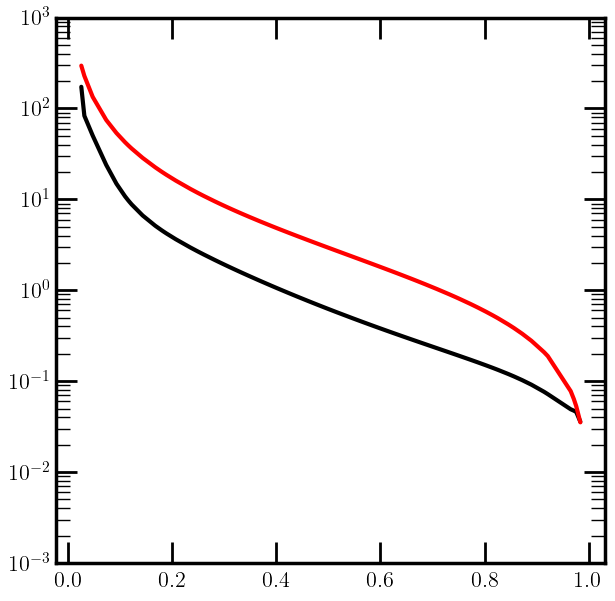

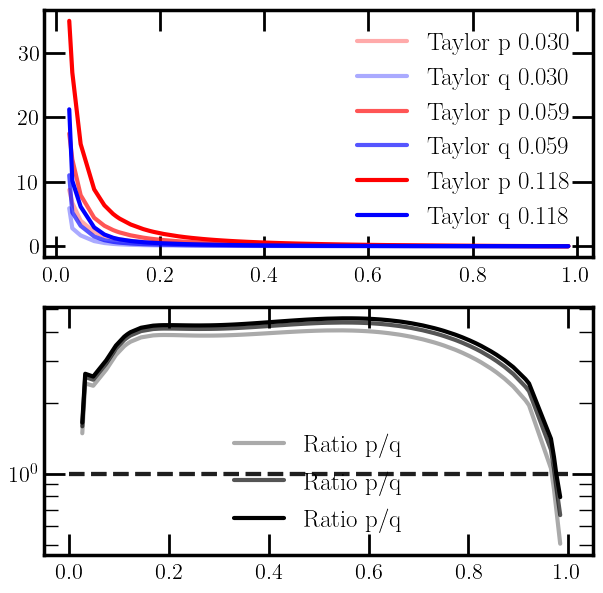

In [ ]:

alpha0 = torch.tensor([0.0,])
alphas = torch.tensor([0.118 / 4, 0.118 / 2, 0.118 ])
xs = torch.rand(100, auxiliary_params + 1) * (0.99- 0.01) + 0.01
xs = xs.sort(axis = 0).values
p0 = target_p(xs[:,0], alpha0)
p1 = jacobian(lambda a: target_p(xs[:,0], a), alpha0, vectorize=True)[:,0]

p0_LL = LL_angularity(xs[:,0], alpha0)
p1_LL = jacobian(lambda a: LL_angularity(xs[:,0], a), alpha0, vectorize=True)[:,0]


def q_given_alpha(xs, alpha):   
    return logq_given_alpha(xs, alpha).exp()
q0 = q_given_alpha(xs, alpha0)
q1 = jacobian(lambda a: q_given_alpha(xs, a), alpha0, vectorize=True)[:,0]

def taylor_p(x, alpha):
    print(p0.shape, p1.shape, alpha.shape, alpha0.shape)
    return p0 + p1 * (alpha - alpha0)

def taylor_p_LL(x, alpha):
    return p0_LL + p1_LL * (alpha - alpha0)

def taylor_q(x, alpha):
    return q0 + q1 * (alpha - alpha0) 

fig, ax = newplot("full")
plt.plot(xs[:,0].detach().numpy(), q1.detach().numpy(), color = "black", label = "p0")
plt.plot(xs[:,0].detach().numpy(), p1.detach().numpy(), color = "red", label = "p1")
plt.yscale("log")
plt.ylim(1e-3, 1e3)

fig, ax = newplot("full")

# Make subplots, one for a ratio
ax = plt.subplot(2, 1, 1)
ax2 = plt.subplot(2, 1, 2)

for i in range(3):
    alpha = torch.tensor([alphas[i],])
    ys = taylor_p(xs, alpha).detach().numpy()
    ax.plot(xs[:,0].detach().numpy(), ys, color = "red", alpha = (i+1)/3, label = f"Taylor p {alpha.item() : .3f}")
    print(ys.shape)

    ys = taylor_q(xs, alpha).detach().numpy()
    ax.plot(xs[:,0].detach().numpy(), ys, color = "blue", alpha = (i+1)/3, label = f"Taylor q {alpha.item() : .3f}")
    print(ys.shape)

    # ys = target_p(xs[:,0], alpha).detach().numpy()
    # ax.plot(xs[:,0].detach().numpy(), ys, color = "black", alpha = (i+1)/3, label = f"Target {alpha.item() : .3f}")

    plt.yscale("log")
    
    # print(taylor_p(xs, alpha).shape)
    # print(taylor_q(xs, alpha).shape)

    ratio = taylor_p(xs, alpha)[:,0] / taylor_q(xs, alpha)

    ax2.plot(xs[:,0].detach().numpy(), ratio.detach().numpy(), color = "black", alpha = (i+1)/3, label = "Ratio p/q")
    plt.yscale("log")

    # line at 1
    ax2.hlines(1, 0, 1, color = "black", linestyle = "--", alpha = 0.5)

    ax.legend()
    ax2.legend()


In [ ]:
# #  Plot distribution of xs


# samples = flow().sample((100000,)).detach().numpy()
# x_samples = samples[:,0]
# aux_samples = samples[:,1:]

# fig, ax = newplot("column")

# plt.hist(x_samples, bins=100, density=True, color = "red", alpha = 0.5)


# xs = torch.zeros((1000, auxiliary_params + 1))
# xs[:,0] = torch.linspace(-0.5, 1.5, 1000)
# ys = flow().log_prob(xs).exp()

# xs = xs[:,0].detach().numpy().flatten()
# ys = ys.detach().numpy().flatten()
# plt.plot(xs, ys, color = "red")


# plt.plot(xs, target_p(torch.tensor(xs)), color = "blue")

# plt.yscale("log")

# # plot the auxiliary variables
# if auxiliary_params > 0:
#     fig, ax = newplot("column")
#     for i in range(auxiliary_params):
#         plt.hist(aux_samples[:,i], bins=100, density=True, alpha = 0.5, label=f"Aux {i}")
#         plt.plot(xs, ys, color = "red")
#     plt.legend()
